# INFO 4602 Final Project Data

Casey Paul
Serena Rodriguez
Rachel Silverstein
Dallas Walton
Lily Kamas

## Import libraries

In [16]:
import pandas as pd
import numpy as np
import requests, os, re, time
from bs4 import BeautifulSoup
from urllib.parse import quote, unquote
from datetime import datetime
from io import BytesIO

# Spatial libaries
import geopandas as gpd
import geoplot, contextily


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sb

## Sales reports
The Colorado Department of Revenue's [Manrijuana Sales Reports](https://revenue.colorado.gov/data-and-reports/marijuana-data/marijuana-sales-reports) stores Excel files on a Google Drive.

Download all excel files. These are files that contain marijuana sales data from January 2014 to Febraury 2021. 

Second, download all the Excel files. 

In [2]:
excel_files = sorted(os.listdir('./COCannabisSalesReport/'))

excel_dictionary = {}

for file in excel_files:
    try:
        _excel_df = pd.read_excel('./COCannabisSalesReport/' + file)

        # Get the date from inside the data
        _date = _excel_df.iloc[1,0].replace('Sales from ','')
        _formatted_date = str(pd.Period(_date))

        # Save
        excel_dictionary[_formatted_date] = _excel_df
    
    except:
        print(file)

Confirm we got them all.

In [3]:
sorted(excel_dictionary.keys())

['2014-01',
 '2014-02',
 '2014-03',
 '2014-04',
 '2014-05',
 '2014-06',
 '2014-07',
 '2014-08',
 '2014-09',
 '2014-10',
 '2014-11',
 '2014-12',
 '2015-01',
 '2015-02',
 '2015-03',
 '2015-04',
 '2015-05',
 '2015-06',
 '2015-07',
 '2015-08',
 '2015-09',
 '2015-10',
 '2015-11',
 '2015-12',
 '2016-01',
 '2016-02',
 '2016-03',
 '2016-04',
 '2016-05',
 '2016-06',
 '2016-07',
 '2016-08',
 '2016-09',
 '2016-10',
 '2016-11',
 '2016-12',
 '2017-01',
 '2017-02',
 '2017-03',
 '2017-04',
 '2017-05',
 '2017-06',
 '2017-07',
 '2017-08',
 '2017-09',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-01',
 '2019-02',
 '2019-03',
 '2019-04',
 '2019-05',
 '2019-06',
 '2019-07',
 '2019-08',
 '2019-09',
 '2019-10',
 '2019-11',
 '2019-12',
 '2020-01',
 '2020-02',
 '2020-03',
 '2020-04',
 '2020-05',
 '2020-06',
 '2020-07',
 '2020-08',
 '2020-09',
 '2020-10',
 '2020-11',
 '20

Define a function to parse the files.

In [4]:
def clean_excel(_df):
    
    # Drop first 5 rows
    _df = _df.drop(index=range(5)).reset_index(drop=True)
    
    # Drop empty column
    _df = _df.dropna(how='all',axis=1)
    
    # Rename columns
    _df.columns = ['Med County','Med Sales','Rec County','Rec Sales']
    
    # Find row for last medical and recreational sales
    last_med = _df[_df['Med County'].str.contains('Sum of NR Counties').fillna(False)].first_valid_index() - 1
    last_rec = _df[_df['Rec County'].str.contains('Sum of NR Counties').fillna(False)].first_valid_index() - 1

    # Slice to only those values
    med_sales = _df.loc[:last_med,['Med County','Med Sales']]
    rec_sales = _df.loc[:last_rec,['Rec County','Rec Sales']]
    
    # Rename columns
    med_sales.columns = ['County','Sales']
    rec_sales.columns = ['County','Sales']

    # Add type
    med_sales['Type'] = 'Medical'
    rec_sales['Type'] = 'Recreational'
    
    # Concatenate
    combined_df = pd.concat([med_sales,rec_sales],ignore_index=True)
    combined_df = combined_df.replace({'Sales':{'NR':np.nan}})

    return combined_df

Test one of the dictionary keys

In [5]:
clean_excel(excel_dictionary['2014-01'])

,County,Sales,Type
0,Adams,683098.0,Medical
1,Alamosa,NaN,Medical
2,Arapahoe,1188232.0,Medical
3,Archuleta,NaN,Medical
4,Boulder,3417873.0,Medical
5,Chaffee,83714.0,Medical
6,Clear Creek,143736.0,Medical
7,Costilla,NaN,Medical
8,Denver,15351083.0,Medical
9,Eagle,203060.0,Medical


Loop through files, parse out relevant data, and concatenate results together.

In [6]:
cleaned_dict = {}

# Apply the function to each month's spreadsheet
for _month, _df in excel_dictionary.items():
    try:
        cleaned_dict[_month] = clean_excel(_df)
    except:
        print(_month)
        pass

# Combine all the months of data together
sales_df = pd.concat(cleaned_dict.values(),keys=cleaned_dict.keys())

# Cleanup
sales_df = sales_df.reset_index(0).reset_index(drop=True)
sales_df = sales_df.rename(columns={'level_0':'Time'})

sales_df = sales_df.sort_values(['Time','County','Type'])

# Write to disk
sales_df.to_csv('colorado_monthly_cannabis_sales.csv',index=False)

print(sales_df.shape)
sales_df.tail()

2021-01
2021-02
2020-11
2020-12
(5538, 4)


,Time,County,Sales,Type
4710,2020-10,Sedgwick,1251442.0,Recreational
4671,2020-10,Summit,NaN,Medical
4711,2020-10,Summit,2409245.0,Recreational
4672,2020-10,Weld,373466.0,Medical
4712,2020-10,Weld,2966860.0,Recreational


## Crime Reports

https://coloradocrimestats.state.co.us/public/Browse/browsetables.aspx

Read in data from the site above. This is the number of DUI arrests for each county in Colorado.

In [7]:
co_dui_data = pd.read_csv("DUI Arrests by Month.csv",skiprows=4).dropna(how='all',axis=1)
co_dui_data.head()

,Arrest Date,Arrest Month,Jurisdiction by Geography,Number of Arrestees
0,Total,January,Total,"14,259"
1,Total,January,Adams County,"2,212"
2,Total,January,Alamosa County,27
3,Total,January,Arapahoe County,451
4,Total,January,Archuleta County,20


Use a Boolean index to filter the data. The new filtered dataframe will no include any `'Arrest Date'` or `'Jurisdiction by Geography'` rows that contain the word 'Total'.

Create a new column titled `Timestamp` that includes the month and year of the arrests. Combine two columns to do this.

In [8]:
co_dui_data = co_dui_data[co_dui_data['Arrest Date'] != 'Total']
co_dui_data = co_dui_data[co_dui_data['Jurisdiction by Geography'] != 'Total']

# Fill any NaNs with 0
# If there is an NaN, this probably means there were no DUI arrests in that county that month.
co_dui_data = co_dui_data.fillna(0)
co_dui_data = co_dui_data.reset_index(drop=True)


co_dui_data["Timestamp"] = co_dui_data['Arrest Month'] + " "+ co_dui_data["Arrest Date"]
co_dui_data.head()

,Arrest Date,Arrest Month,Jurisdiction by Geography,Number of Arrestees,Timestamp
0,2014,January,Adams County,350,January 2014
1,2014,January,Alamosa County,0,January 2014
2,2014,January,Arapahoe County,72,January 2014
3,2014,January,Archuleta County,1,January 2014
4,2014,January,Baca County,2,January 2014


Now that we have a new column with the combined month and year, we can drop the columns we got that data from.

In [9]:
co_dui_data = co_dui_data.drop(columns=['Arrest Date','Arrest Month'])
co_dui_data.head()

,Jurisdiction by Geography,Number of Arrestees,Timestamp
0,Adams County,350,January 2014
1,Alamosa County,0,January 2014
2,Arapahoe County,72,January 2014
3,Archuleta County,1,January 2014
4,Baca County,2,January 2014


Convert `Timestamp` column to a datetime object.

In [10]:
# Convert to datetime
co_dui_data['Timestamp'] = pd.to_datetime(co_dui_data['Timestamp'])

co_dui_data.head()

,Jurisdiction by Geography,Number of Arrestees,Timestamp
0,Adams County,350,2014-01-01
1,Alamosa County,0,2014-01-01
2,Arapahoe County,72,2014-01-01
3,Archuleta County,1,2014-01-01
4,Baca County,2,2014-01-01


## Merge datasets.

In order to do this, we need to make sure the columns we are joining on are the same types of data and match one another.

First, convert `Time` to a datetime object.

Next, make sure all counties match (i.e. "Boulder County" vs. "Boulder") To do this, add `" County"` to the county names in `sales_df`. 

In [11]:
sales_df['Time'] = pd.to_datetime(sales_df['Time'])

sales_df['County'] = sales_df['County'] + " County"

sales_df = sales_df.fillna(0)

sales_df.head()

,Time,County,Sales,Type
0,2014-01-01,Adams County,683098.0,Medical
33,2014-01-01,Adams County,0.0,Recreational
1,2014-01-01,Alamosa County,0.0,Medical
2,2014-01-01,Arapahoe County,1188232.0,Medical
3,2014-01-01,Archuleta County,0.0,Medical


Now merge the two dataframes in a new dataframe named `combined_df`. Drop any duplicate columns and be sure to fill in NaNs with 0.

In [12]:
combined_df = pd.merge(left = co_dui_data,
                       right = sales_df,
                       how = 'inner',
                       left_on = ['Jurisdiction by Geography', 'Timestamp'],
                        right_on = ['County',"Time"]
                    )
combined_df= combined_df.drop(columns = ['Timestamp', 'Jurisdiction by Geography'])
combined_df = combined_df.fillna(0)

combined_df.tail()

,Number of Arrestees,Time,County,Sales,Type
5533,0,2020-10-01,Sedgwick County,1251442.0,Recreational
5534,12,2020-10-01,Summit County,0.0,Medical
5535,12,2020-10-01,Summit County,2409245.0,Recreational
5536,62,2020-10-01,Weld County,373466.0,Medical
5537,62,2020-10-01,Weld County,2966860.0,Recreational


## County shapefile

Read in the "co_counties" shapefiles. If we want to do anything with geopandas we will need this file.

In [13]:
co_counties_gdf = gpd.read_file('co_counties/co_counties.shp')
co_counties_gdf.head()

,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle,geometry
0,1.0,ADAMS,154502.0,441603.0,3.064413e+09,392729.110497,0.0,0.0,"POLYGON ((-103.70574 39.99991, -103.70569 39.9..."
1,3.0,ALAMOSA,6008.0,15445.0,1.872295e+09,177555.351470,0.0,0.0,"POLYGON ((-105.59917 37.75216, -105.51619 37.7..."
2,5.0,ARAPAHOE,225124.0,572003.0,2.084863e+09,335003.471310,0.0,0.0,"MULTIPOLYGON (((-103.70653 39.73986, -103.7066..."
3,7.0,ARCHULETA,5257.0,12084.0,3.504795e+09,263558.683443,0.0,0.0,"POLYGON ((-107.12854 37.42287, -107.12881 37.3..."
4,11.0,BENT,1835.0,6499.0,3.990976e+09,254662.200852,0.0,0.0,"POLYGON ((-102.74208 38.26675, -102.74211 38.2..."


## Visuals

### Monthly Medical vs. Recreational sales in Colorado
Reshape the data with "Time" in the index and "Medical" and "Recreational" as columns and the total number of sales as values. Save the resulting reshape as monthly_sales_pivot. You can do this with a pivot table or a groupby-aggregation. Show the tail of this reshaped DataFrame.

In [14]:
monthly_sales_pivot = pd.pivot_table(sales_df,
                                      index='Time',
                                      columns='Type',
                                      values='Sales',
                                      aggfunc='sum'
                                )
monthly_sales_pivot.tail()

Type,Medical,Recreational
Time,,
2020-06-01,39628326.0,152754961.0
2020-07-01,41985544.0,176676875.0
2020-08-01,40904451.0,169071513.0
2020-09-01,38685046.0,160055956.0
2020-10-01,37491986.0,155963920.0


<AxesSubplot:title={'center':'Medical and Recreational Cannabis Sales by Month'}, xlabel='Year', ylabel='Number of Sales'>

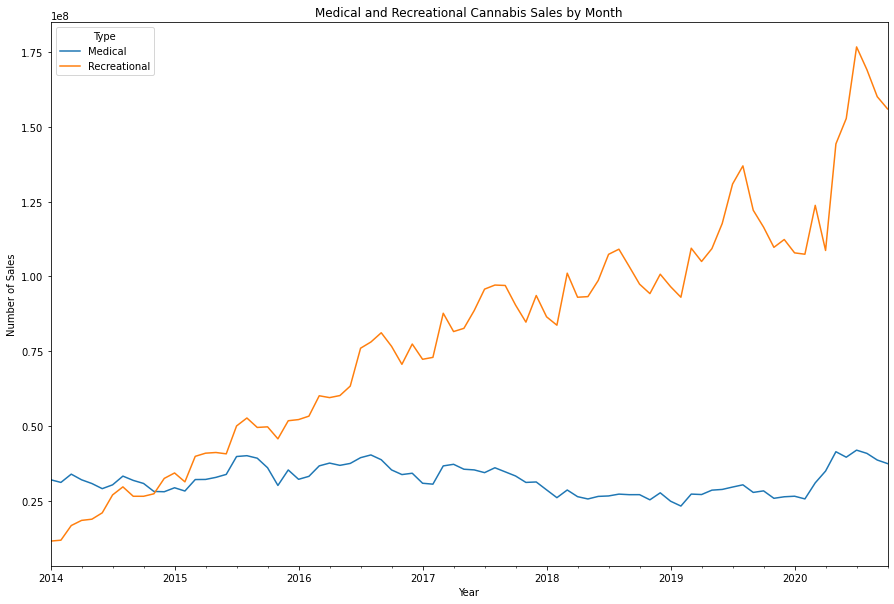

In [17]:
f,ax = plt.subplots(figsize=(15,10))

monthly_sales_pivot.plot(ax=ax,
                         title = 'Medical and Recreational Cannabis Sales by Month',
                         xlabel = 'Year',
                         ylabel = 'Number of Sales'
                        )

### Monthly Medical vs. Recreational sales in Boulder County

Filter original sales DataFrame to only that Boulder county's values. Note that not all counties permit medical and/or recreational sales and thus may not be present in the data or they have changed their policies over time creating gaps. Reshape the data to include recreational and medical like we did above. Save the result as `county_monthly_sales_pivot`. 

In [20]:
# Boolean index to only Boulder data
boulder_sales_df = sales_df[sales_df['County'] == 'Boulder County']

# Pivot data to get total medical and recreational sales
county_monthly_sales_pivot = pd.pivot_table(boulder_sales_df,
                                            index='Time',
                                            columns='Type',
                                            values='Sales',
                                            aggfunc='sum'
                                           )
# Inspect
county_monthly_sales_pivot.tail()

Type,Medical,Recreational
Time,,
2020-06-01,1306408.0,10759641.0
2020-07-01,1309949.0,12593191.0
2020-08-01,1356988.0,12547631.0
2020-09-01,1363396.0,11745758.0
2020-10-01,1382416.0,11622740.0


<AxesSubplot:title={'center':'Medical and Recreational Cannabis Sales by Month'}, xlabel='Year', ylabel='Number of Sales'>

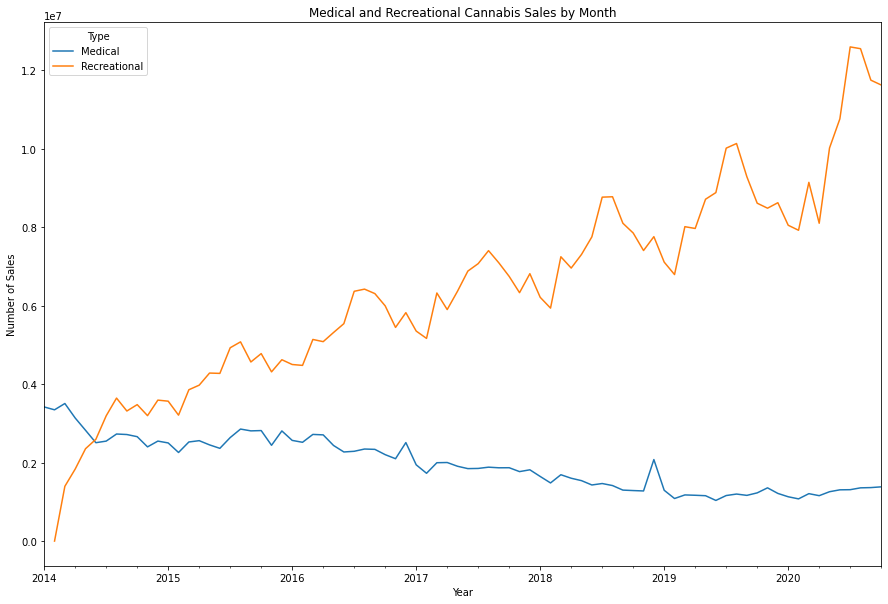

In [21]:
f,ax = plt.subplots(figsize=(15,10))

county_monthly_sales_pivot.plot(ax=ax,
                         title = 'Medical and Recreational Cannabis Sales by Month',
                         xlabel = 'Year',
                         ylabel = 'Number of Sales'
                        )

In [28]:
monthly_crime_pivot = pd.pivot_table(combined_df,
                                      index='Time',
                                      columns='Type',
                                      values='Number of Arrestees',
                                      aggfunc='sum'
                                )
monthly_crime_pivot.tail()

,Type,Medical
Time,,
2018-08-01,Number of Arrestees,2548471611231181415595015512220158343372154619...
2019-04-01,Number of Arrestees,2524485312595161949271511212127425910571112316...
2019-08-01,Number of Arrestees,2347444472411722239103914115912833241414181762...
